In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, ReLU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2  # Import L2 regularizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os
import numpy as np
import random

In [4]:
# Function to preprocess spectrograms
def preprocess_spectrogram(spectrogram, target_size):
    # Normalize
    spectrogram = spectrogram / np.max(spectrogram)
    # Resize to match MobileNet input
    spectrogram = tf.image.resize(spectrogram, target_size)
    # Convert to 3 channels (stack the same data for all channels)
    spectrogram = tf.image.grayscale_to_rgb(spectrogram)
    return spectrogram.numpy()

# Data augmentation for spectrograms
def augment_spectrogram(spectrogram):
    # Time shifting
    shift = random.randint(-10, 10)
    spectrogram = np.roll(spectrogram, shift, axis=1)

    # Frequency masking
    freq_mask = random.randint(0, 10)
    spectrogram[:, freq_mask:freq_mask + 10, :] = 0

    # Time masking
    time_mask = random.randint(0, 10)
    spectrogram[time_mask:time_mask + 10, :, :] = 0

    return spectrogram



# Load and preprocess spectrogram dataset
def load_data(image_folder, txt_folder, target_size):
    image_paths = []
    labels = []

    # Read labels and corresponding spectrogram paths
    for txt_file in os.listdir(txt_folder):
        if txt_file.endswith('.txt'):
            with open(os.path.join(txt_folder, txt_file), 'r') as file:
                label = int(file.read().strip())
                image_name = os.path.splitext(txt_file)[0] + '.jpg'  # Assuming spectrograms are in .jpg format
                image_path = os.path.join(image_folder, image_name)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
                    labels.append(label)

    # Preprocess spectrograms
    X = []
    y = []
    for img_path, label in zip(image_paths, labels):
        spectrogram = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale')
        spectrogram = tf.keras.preprocessing.image.img_to_array(spectrogram)
        spectrogram = preprocess_spectrogram(spectrogram, target_size)
        spectrogram = augment_spectrogram(spectrogram)  # Apply augmentation
        X.append(spectrogram)
        y.append(label)

    return np.array(X), np.array(y)


In [5]:
model_path = 'final_Exp_MV2.keras'  # Replace with your saved model path
print(f"Loading model from: {model_path}")
model = tf.keras.models.load_model(model_path)

Loading model from: final_Exp_MV1.keras


Number of test images: 7000
Shape of X_test: (7000, 128, 128, 3)
Shape of y_test: (7000,)
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step

Evaluation Metrics:
Accuracy: 0.9817
Precision: 1.0000
Recall: 0.9817
F1 Score: 0.9908
ROC AUC Score: Not defined (only one class present in y_test).


<Figure size 800x600 with 0 Axes>

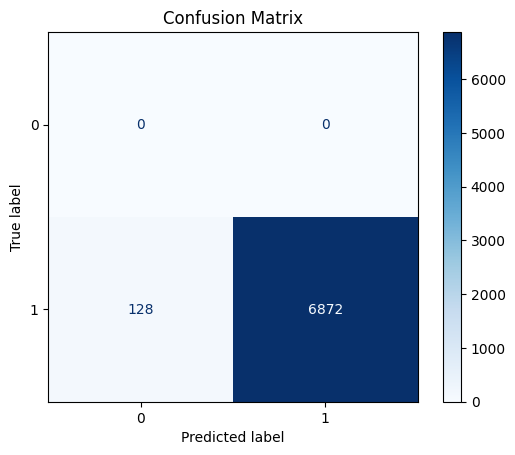

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Load test data
test_image_folder = 'Dataset_Model/classified_test_images/12_18_test_images'  # Replace with your test spectrogram images path
test_txt_folder = 'Dataset_Model/classified_test_images/12_18_test_labels'  # Replace with your test labels path
X_test, y_test = load_data(test_image_folder, test_txt_folder, (128, 128))

print(f"Number of test images: {len(X_test)}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Check for multiple classes in y_test before computing ROC AUC
if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC AUC Score: {roc_auc:.4f}")
else:
    print("ROC AUC Score: Not defined (only one class present in y_test).")

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

Number of test images: 9000
Shape of X_test: (9000, 128, 128, 3)
Shape of y_test: (9000,)
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step

Evaluation Metrics:
Accuracy: 0.9348
Precision: 0.9329
Recall: 0.9985
F1 Score: 0.9646
ROC AUC Score: 0.9860


<Figure size 800x600 with 0 Axes>

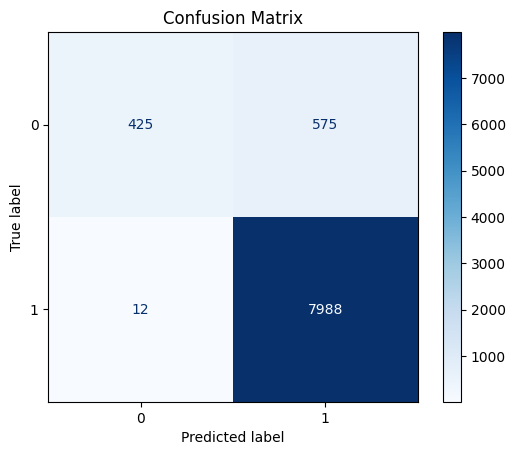

In [9]:
# Load test data
test_image_folder = 'Dataset_Model/classified_test_images/18_100_test_images'  # Replace with your test spectrogram images path
test_txt_folder = 'Dataset_Model/classified_test_images/18_100_test_labels'  # Replace with your test labels path
X_test, y_test = load_data(test_image_folder, test_txt_folder, (128, 128))

print(f"Number of test images: {len(X_test)}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Check for multiple classes in y_test before computing ROC AUC
if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC AUC Score: {roc_auc:.4f}")
else:
    print("ROC AUC Score: Not defined (only one class present in y_test).")

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()